In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-22 10:03:42.932393: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-22 10:03:44.449694: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 10:03:44.609252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:03:44.611822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:03:44.611841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 10:03:44.615744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 

In [4]:
R = Runner(verbose=True, classifier='kunet2d')

2023-04-22 10:03:47.067848: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 10:03:47.306702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:03:47.309115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 10:03:47.318564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2  KUNet2D ***
Working directory: /tmp/tmp_gt729lpGP2
Verbose mode active!
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 16) 144         input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 16) 64          unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 16) 0           unet_down0_0_bn[0][0]            
________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 10

In [ ]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier(patience_counter=4)
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-22 10:03:58.274514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-22 10:03:58.294991: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-22 10:04:02.243231: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-22 10:04:02.951168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-22 10:04:03.599268: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-22 10:04:03.599296: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-22 10:04:03.599354: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 10:04:03.607153: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 10:04:04.351098: I tensorflow/stream_exec

250/250 [==============================] - 35s 109ms/step - loss: 0.1576 - dice_coef: 0.5912 - val_loss: 0.1974 - val_dice_coef: 0.6708


2023-04-22 10:04:38.125378: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
250/250 [==============================] - 26s 103ms/step - loss: 0.0587 - dice_coef: 0.7970 - val_loss: 4.9335 - val_dice_coef: 0.6045
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 0.0583 - dice_coef: 0.8161

In [ ]:
R.classifier_scores

In [ ]:
R.discriminator_scores

In [ ]:
R.plot()

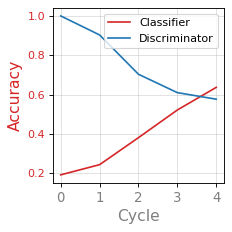

In [18]:
R.plot()

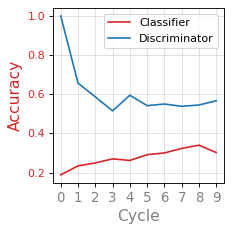

In [18]:
R.plot()

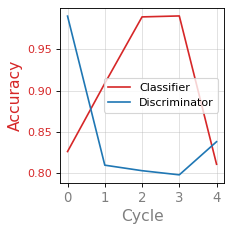

In [17]:
R.plot()